In [46]:
%reset -f
%matplotlib inline

In [47]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

import datetime

from scipy.io import savemat

from cycling_rnn import *

In [48]:
cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
sns.set_palette(cmap)

In [49]:
monkey = 'C'

In [50]:
if monkey=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb.mat')

In [51]:
m1 = data['D'][0,0]['M1']
emg = data['D'][0,0]['EMG']

m1 = np.reshape(m1, m1.shape[:2]+(4,)) # order = 'C' or 'F'
emg = np.reshape(emg, emg.shape[:2]+(4,)) # order = 'C' or 'F'

m1 = np.transpose(m1, [1,2,0])
emg = np.transpose(emg, [1,2,0])

print 'M1 shape '+str(m1.shape)
print 'EMG shape '+str(emg.shape)

M1 shape (5333, 4, 109)
EMG shape (5333, 4, 22)


In [52]:
kin = data['D'][0,0]['KIN']
kin = np.reshape(kin.mean(-1), kin.shape[:2]+(4,))
kin = np.transpose(kin, [1, 2, 0])
# 0 hp
# 1 hv
# 2 tq
# 3 vp
# 4 vv
# 5 w


In [53]:
from scipy import signal

In [134]:
inds = signal.argrelmin(kin[:,0,0]**2)[0]
inds = inds[inds > 1500]
inds = inds[inds < 4500]
inds1 = inds[:-1:2]
inds2 = inds[1::2]
print inds
print inds1
print inds2

[1846 2094 2304 2526 2731 2948 3152 3367 3573 3792 4004 4235 4471]
[1846 2304 2731 3152 3573 4004]
[2094 2526 2948 3367 3792 4235]


In [135]:
np.arange(inds2[0],inds2[-1],25)

array([2094, 2119, 2144, 2169, 2194, 2219, 2244, 2269, 2294, 2319, 2344,
       2369, 2394, 2419, 2444, 2469, 2494, 2519, 2544, 2569, 2594, 2619,
       2644, 2669, 2694, 2719, 2744, 2769, 2794, 2819, 2844, 2869, 2894,
       2919, 2944, 2969, 2994, 3019, 3044, 3069, 3094, 3119, 3144, 3169,
       3194, 3219, 3244, 3269, 3294, 3319, 3344, 3369, 3394, 3419, 3444,
       3469, 3494, 3519, 3544, 3569, 3594, 3619, 3644, 3669, 3694, 3719,
       3744, 3769, 3794, 3819, 3844, 3869, 3894, 3919, 3944, 3969, 3994,
       4019, 4044, 4069, 4094, 4119, 4144, 4169, 4194, 4219])

In [136]:
print np.diff(inds1).mean()
print np.diff(inds2).mean()

431.6
428.2


In [137]:
t_inds1, t_inds2 = get_time_inds(data)

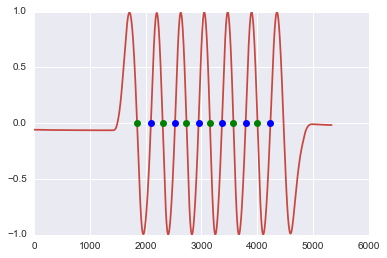

In [138]:
plt.plot(kin[:,0,0])
plt.plot([inds2], 0, 'bo')
plt.plot([inds1], 0, 'go')
plt.show()

## EMG plot

In [20]:
emg_.shape

(80, 4, 36)

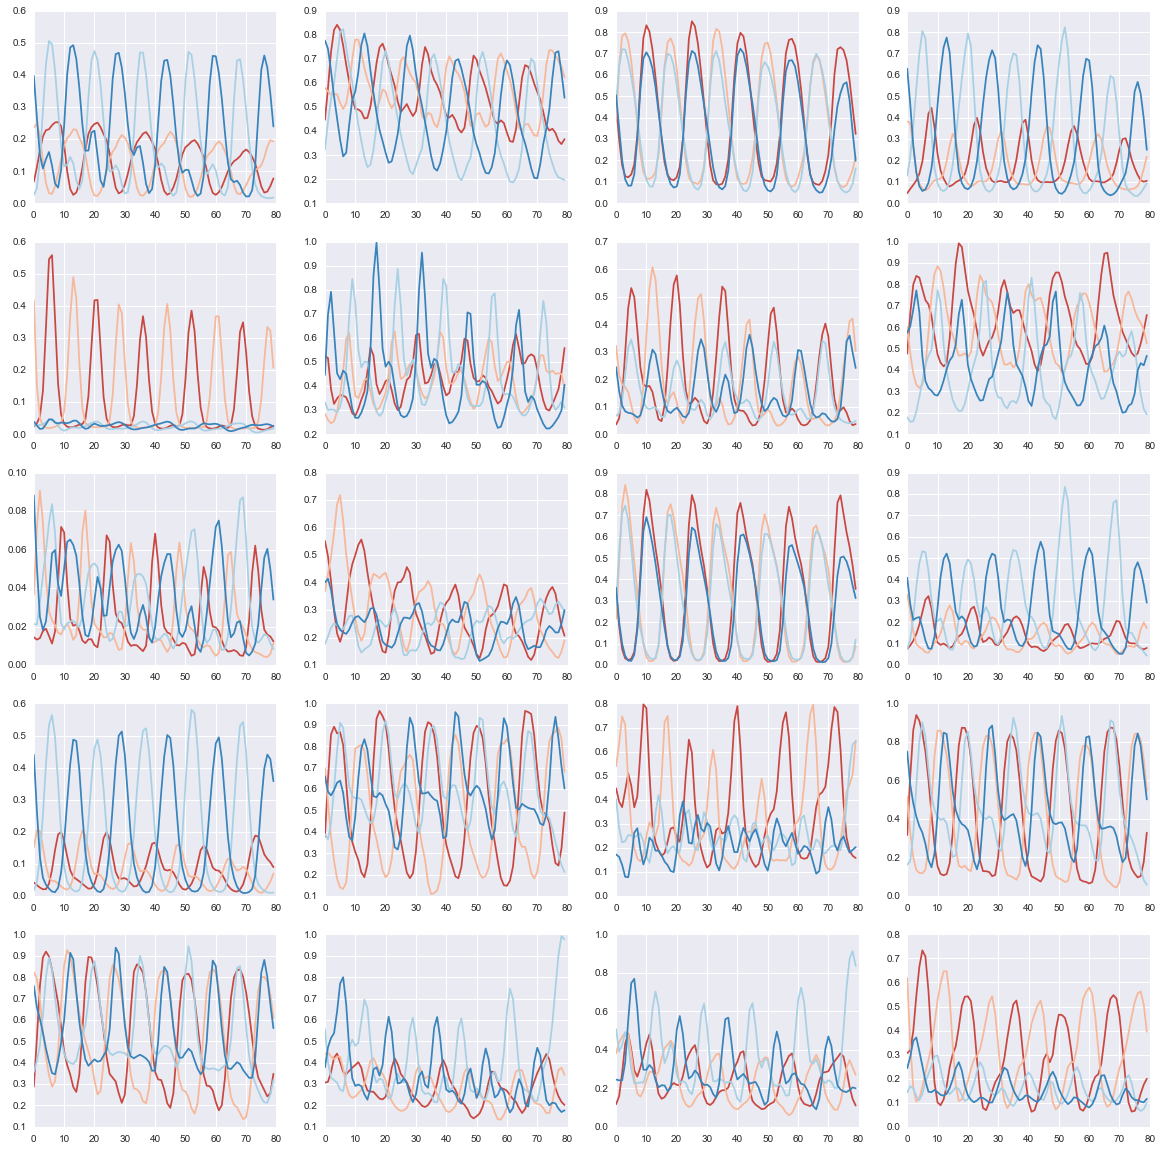

In [19]:
rows = 5
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(emg_[:,:,muscle])
        #ax[i,j].set_xlim((500,5000))
        #ax[i,j].set_title(str(muscle))
plt.show()

## Preprocess data

In [15]:
# Normalize EMG
max_ = np.max(emg, axis=(0,1))
min_ = np.min(emg, axis=(0,1))
emg_ = (emg - min_)/(max_ - min_)

# Normalize M1
max_ = np.max(m1, axis=(0,1))
min_ = np.min(m1, axis=(0,1))
m1_ = m1/(max_ - min_ + 5)

In [472]:
def get_canon(inds_):
    can_out = (len(inds_)-1)*[None]
    for i in range(len(inds_)-1):
        can_out[i] = emg_[inds_[i]:inds_[i+1]]
        period = int(np.round(np.diff(inds_).mean()))
        can_out[i] = signal.resample(can_out[i], period)
    can_out = np.stack(can_out).mean(axis=0)
    return np.tile(can_out, (10,1,1)), period
canon1, p1 = get_canon(inds1)
canon2, p2 = get_canon(inds2)
canon = np.mean(np.stack([canon1[p1/2:], canon2[:-p1/2+1]]), axis=0)

In [17]:
# Select times + downsample 
#times = np.arange(2000,4000, 25)
times = np.arange(inds2[0],inds2[-1],25)
m1_ = m1[times]
emg_ = emg_[times]

## Set up PCA for plotting

In [428]:
pca_emg = sk.decomposition.PCA(n_components=5)
pca_m1 = sk.decomposition.PCA(n_components=5)

pca_emg.fit(np.concatenate([emg_[:,i,:] for i in range(4)]))
pca_m1.fit(np.concatenate([m1_[:,i,:] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

In [429]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
#     for i in range(g.axes.shape[0]):
#         for j in range(g.axes.shape[1]):
#             if i != j:
#                 g.axes[i,j].set_xlim(-dmax,dmax)
#                 g.axes[i,j].set_ylim(-dmax,dmax)
    
    g.add_legend()

#### PC plots, EMG

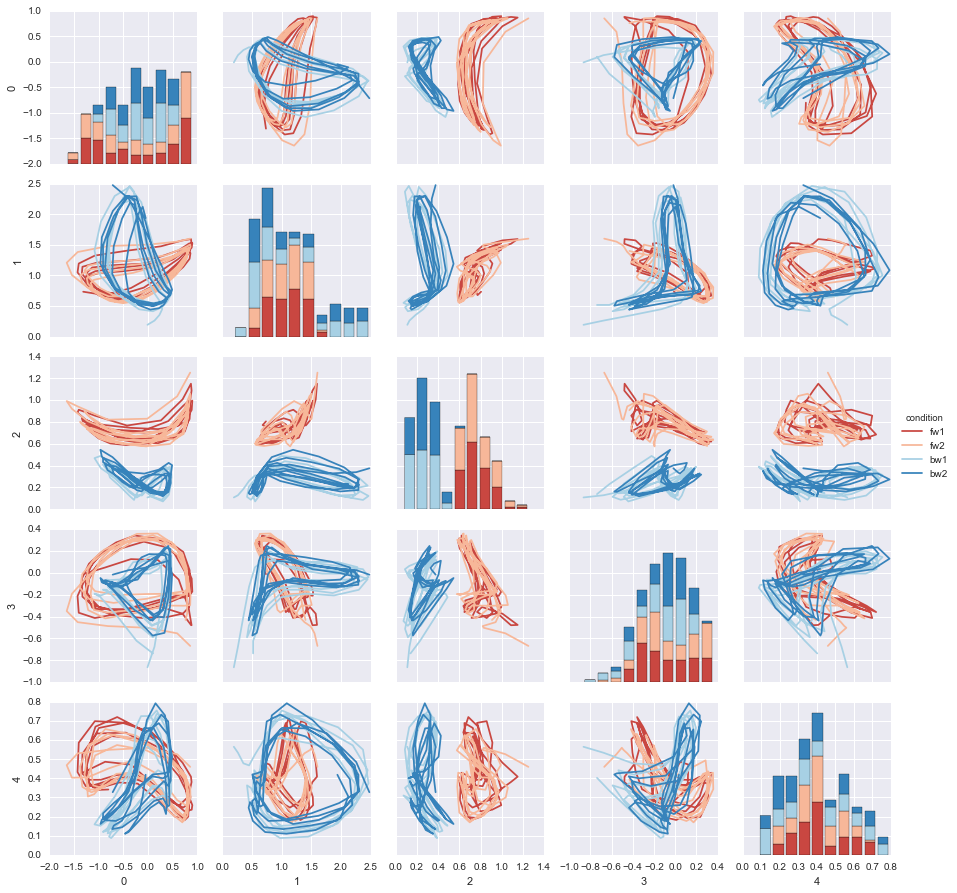

In [430]:
make_pairgrid([np.dot(emg_[:,i,:], pca_emg.components_.T) for i in range(4)])

#### PC plots, M1

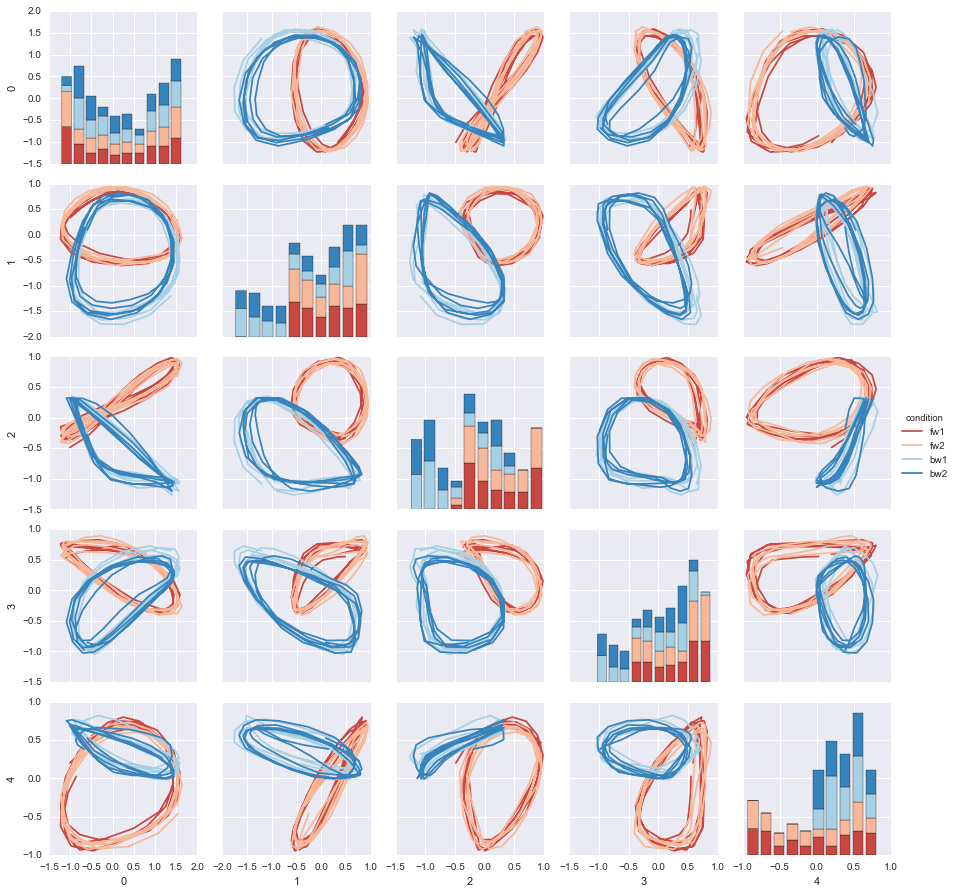

In [431]:
make_pairgrid([np.dot(m1_[:,i,:], pca_m1.components_.T) for i in range(4)])

## Set up input and output data for tensorflow

In [13]:
# # Some batch-related functions
# def hankelize(a, time_steps_):
#     """
#     Convert size (T,n) matrix to size (num_steps, T-num_steps+1 , n) tensor.
#     Different batches can now be selected by a[:,batch_inds,:].
#     """
#     dims = a.shape
#     T_new_ = dims[0] - time_steps_ + 1
#     b = np.zeros((T_new_, time_steps_) + dims[1:])
#     for i in range(T_new_):
#         b[i,:,:] = a[i:i+time_steps_, :]
#     inds = range(b.ndim)
#     inds[0], inds[1] = inds[1], inds[0]
#     b = np.transpose(b, inds) # |
#     return b

# def get_rand_batch(data_, batch_size_):
#     '''
#     args:
#     return:
#     '''
#     inds = np.random.choice(data_[0].shape[1], batch_size_)
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return inds, data_

# def get_next_batch(data_, batch_counter_):
#     """  """
#     batch_counter += 1
#     for i in range(len(data_)):
#         data_[i] = data_[i][:,inds,:]
#     return data_

In [491]:
# Time and batch parameters
time_steps = emg_.shape[0]
# batch_size = 4
# T = emg_.shape[0]
#T_new = T - time_steps + 1

In [433]:
# y_data_h = hankelize(emg_, time_steps)
# print y_data_h.shape

In [434]:
# # even partition
# y_data_e = y_data_h[:, :y_data_h.shape[1]:time_steps, :]
# print y_data_e.shape

In [435]:
# y_data = np.concatenate([y_data_e[:,:,:,i] for i in range(4)], axis=1)
# print y_data.shape

In [487]:
# output data: normalized muscles
y_data = emg_

In [488]:
# input data:
# u = [1,0,0,0] for all times for condition 1.
# u = [0,1,0,0] for all times for condition 2.
# etc.
m = 4
u_data = np.zeros(y_data.shape[:2]+(m,))
for i in range(4):
    u_data[:,i,i] = 1

In [489]:
# check to make sure they are equal
print emg_.size
print y_data.size

11520
11520


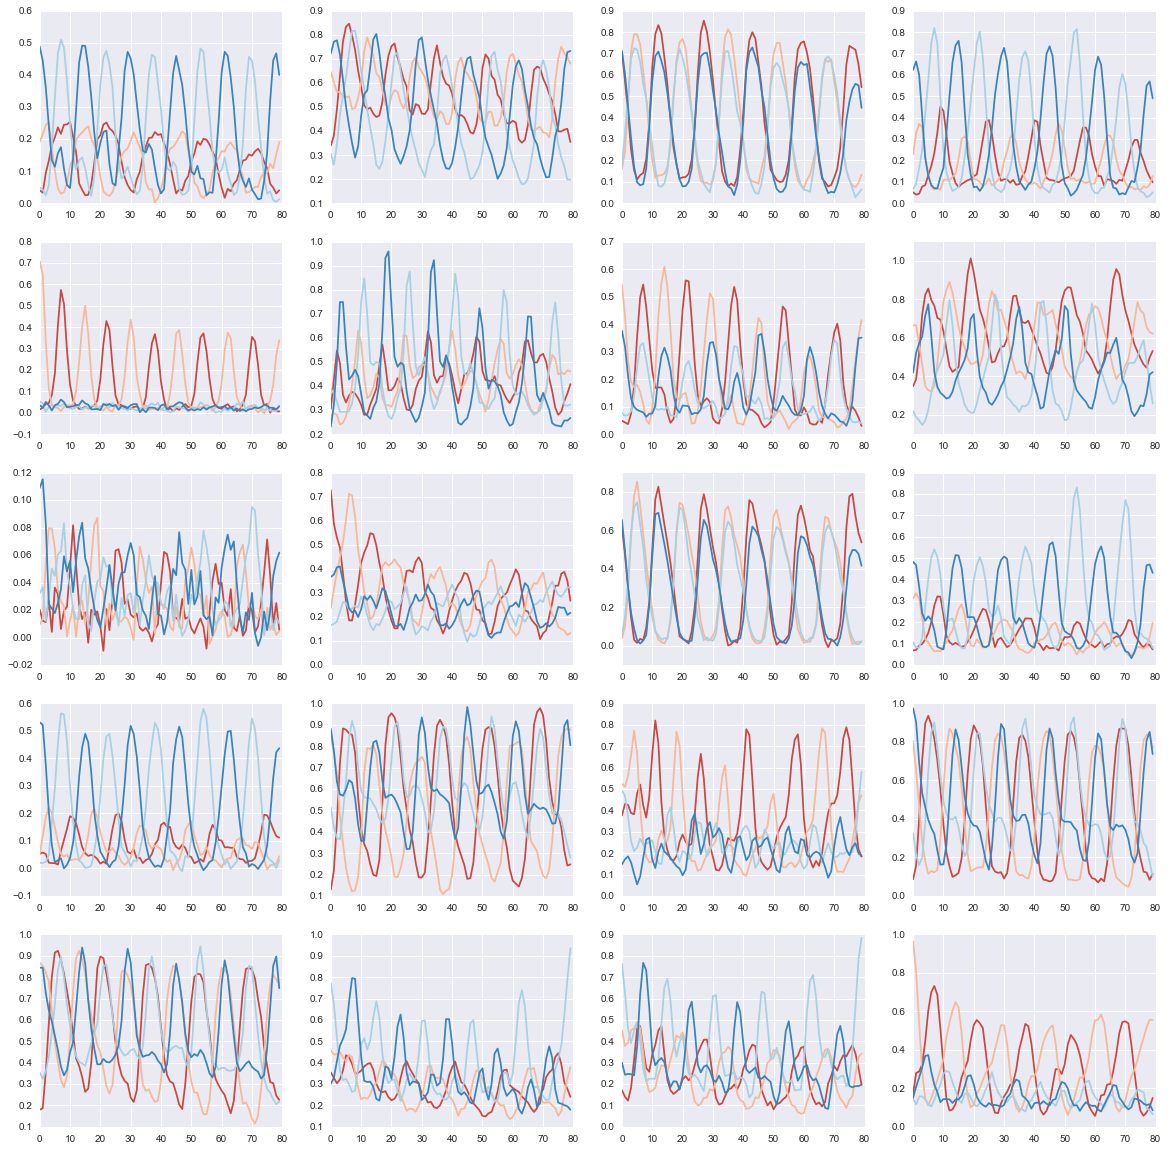

In [448]:
rows = 5
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        y_plot = y_data + np.random.randn(*y_data.shape)*y_data.var()*0.2
        ax[i,j].plot(y_plot[:,:,muscle])
        #ax[i,j].set_title(str(muscle))
plt.show()

## Test class stufff

In [21]:
import cycling_rnn

In [30]:
m = u_data.shape[-1] # m = 4 inputs
n = 100 # n = 100 neurons
p = y_data.shape[-1] # p = 36 muscles
total_batches = y_data.shape[1]

80

In [34]:
RNN = cycling_rnn.RNN(m,n,p,time_steps,total_batches,time_steps)

In [36]:
tf.reset_default_graph()
RNN.build_graph()

TypeError: Expected binary or unicode string, got None

In [24]:
tf.all_variables()

[]

## Build tensorflow graph

In [495]:
tf.reset_default_graph()

m = u_data.shape[-1] # m = 4 inputs
n = 100 # n = 100 neurons
p = y_data.shape[-1] # p = 36 muscles
total_batches = y_data.shape[1]

x0 = tf.Variable(tf.random_normal([total_batches,n], stddev=0.01), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=1/np.sqrt(n)), name='C')
d = tf.Variable(tf.constant(0.01, shape=[1,p]), name='d')

B = tf.Variable(tf.random_normal([m,n], stddev=1/np.sqrt(n)), name='B')

U = tf.placeholder(tf.float32, [time_steps, None, m], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')

U_ = tf.unpack(U)
U_ = [tf.matmul(U_[i], B) for i in range(time_steps)]
U_ = tf.pack(U_)

cell = tf.nn.rnn_cell.BasicRNNCell(n)
cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell,p)
#cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=0.5)
output, state = tf.nn.dynamic_rnn(cell, U_, initial_state=x0, dtype=tf.float32, time_major=True)

#Y_hat = tf.unpack(output)
#Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
#Y_hat = tf.pack(Y_hat)

#output_diff = tf.gather(output, range(1,time_steps))-tf.gather(output, range(0,time_steps-1))

#Get A matrix
with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    A = tf.get_variable('Matrix')
    b = tf.get_variable('Bias')

In [500]:
[tf.all_variables()[i].name for i in range(len(tf.all_variables()))]

[u'x0:0',
 u'C:0',
 u'd:0',
 u'B:0',
 u'RNN/BasicRNNCell/Linear/Matrix:0',
 u'RNN/BasicRNNCell/Linear/Bias:0',
 u'RNN/OutputProjectionWrapper/Linear/Matrix:0',
 u'RNN/OutputProjectionWrapper/Linear/Bias:0']

In [502]:
tf.all_variables()[-1].get_shape()

TensorShape([Dimension(36)])

In [ ]:
beta1 = 0.0
beta2 = 0.0
gamma = 0.0
cost = tf.reduce_mean((Y_hat - Y)**2)
+beta1*tf.nn.l2_loss(A)
+beta2*tf.nn.l2_loss(C) 
#+gamma*tf.nn.l2_loss(output_diff)
        
train_op = tf.train.AdamOptimizer(learning_rate=0.0001) # 0.0001 
# add gradient_noise? 
#grads_and_vars = train_op.compute_gradients(cost)
opt_op = train_op.minimize(cost)

In [ ]:
tf.scalar_summary('loss', cost)

tf.histogram_summary('A', A)
tf.histogram_summary('B', B)
tf.histogram_summary('b', b)
tf.histogram_summary('C', C)
tf.histogram_summary('d', d)
tf.histogram_summary('x0', x0)

merged_summary_op = tf.merge_all_summaries()

In [ ]:
saver = tf.train.Saver()
cur_run = monkey+'_'+str(datetime.datetime.now().strftime("%m%d-%H%M-%S"))
load_model_path = './saves/'+cur_run
save_model_path = './saves/'+cur_run

In [ ]:
print cur_run

## Train

In [ ]:
with tf.Session() as sess:
    summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs/'+cur_run, graph=sess.graph)
    sess.run(tf.initialize_all_variables())
    #saver.restore(sess, load_model_path) # comment out if not loading

    for i in range(2000):
        feed_dict = {Y: y_data, U: u_data}
        _, loss_val, summary_str = sess.run([opt_op, cost, merged_summary_op], feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, i)

        if i % 500 == 0:
            print 'iter:', '%04d' % (i), \
                  'Loss:', '{:.6f}'.format(loss_val)
            saver.save(sess, save_model_path)

    print 'iter:', '%04d' % (i), \
          'Loss:', '{:.6f}'.format(loss_val)
    saver.save(sess, save_model_path)

    print 'Finished'

    # simulate model
    y_tf, x_tf = sess.run([Y_hat, output], feed_dict=feed_dict)

In [ ]:
# def dehankelize(data_):
#     data_ = np.concatenate([data_[:,i,:] for i in range(data_.shape[1])])
#     data_ = np.reshape(data_, (data_.shape[0]/4, 4, data_.shape[1]), order='F')
#     data_ = np.transpose(data_, (0,2,1))
#     return data_

In [ ]:
# y_tf_ = dehankelize(y_tf)
# x_tf_ = dehankelize(x_tf)

## Plot fit quality

In [ ]:
rows = 4
cols = 2

with sns.color_palette(n_colors=4):
    f, ax = plt.subplots(rows,cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):
            muscle = np.ravel_multi_index((i,j), (rows,cols))
            ax[i,j].plot(emg_[:,:,muscle], linewidth=2, alpha=1)
            ax[i,j].plot(y_tf[:,:,muscle],'--',linewidth=4, alpha=0.5)
            ax[i,j].set_title(str(muscle))
plt.show()

## RNN neuron PC plots

In [ ]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf[:,i,:] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf[:,i,:] for i in range(4)]))

In [ ]:
# plot PCs for the RNN state variable
make_pairgrid([np.dot(x_tf[:,i,:], pca_x.components_.T) for i in range(4)])

## RNN activations

In [ ]:
rows = 10
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        neuron = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(x_tf[:,:,neuron])
        ax[i,j].set_title(str(neuron))
plt.show()

### export to stupid lab

In [ ]:
savestr = '/Users/jeff/Documents/MATLAB/CyclingTask/data/tf_'+cur_run+'.mat'
savemat(savestr, mdict={'X': x_tf})

In [37]:
blah = 'loadpath'

False